In [1]:
import nltk
nltk.download('punkt')

import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report, auc, precision_recall_curve

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load IMDB Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)


word_index = tf.keras.datasets.imdb.get_word_index()
start_char = 1
oov_char = 2


inverted_word_index = dict((i + 3, word) for (word, i) in word_index.items())

inverted_word_index[start_char] = '[START]'
inverted_word_index[oov_char] = '[OOV]'

for i in range(len(x_train)):
  x_train[i] = ' '.join(inverted_word_index[i] for i in x_train[i])

for i in range(len(x_test)):
  x_test[i] = ' '.join(inverted_word_index[i] for i in x_test[i])



x_train = np.concatenate((x_train, x_test[10000:]))
y_train = np.concatenate((y_train, y_test[10000:]))

x_dev = x_train[:10000]
y_dev = y_train[:10000]

x_train = x_train[10000:]
y_train = y_train[10000:]

x_test = x_test[:10000]
y_test = y_test[:10000]

print('\nTraining set shape :', x_train.shape)
print('Development set shape :', x_dev.shape)
print('Test set shape :', x_test.shape)


# flatten_x_train = [token for doc in x_train for token in nltk.tokenize.word_tokenize(doc)]
# print('\nVocabulary size :', len(set(flatten_x_train)) - 3)


def average_doc_length(docs_tokenized):
  doc_sizes = []

  for doc in docs_tokenized:
    doc_sizes.append(len(doc))

  return int(np.mean(np.array(doc_sizes)))


x_train_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_train]
x_dev_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_dev]
x_test_tokenized = [nltk.tokenize.word_tokenize(doc)[3:] for doc in x_test]

print('\nAverage doc length of training set :', average_doc_length(x_train_tokenized))
print('Average doc length of development set :', average_doc_length(x_dev_tokenized))
print('Average doc length of test set :', average_doc_length(x_test_tokenized))

1641221/1641221 [==============================] - 0s 0us/step

Training set shape : (30000,)
Development set shape : (10000,)
Test set shape : (10000,)

Average doc length of training set : 238
Average doc length of development set : 242
Average doc length of test set : 234


In [3]:
target_names = ['negative', 'positive']

print(x_train_tokenized[0])


['i', 'think', 'this', 'is', 'one', 'of', 'the', 'weakest', 'of', 'the', 'kenneth', 'branagh', 'shakespearian', 'works', 'after', 'such', 'great', 'efforts', 'as', 'much', 'ado', 'about', 'nothing', 'etc', 'i', 'thought', 'this', 'was', 'poor', 'the', 'cast', 'was', 'weaker', 'alicia', 'silverstone', 'nivoli', 'mcelhone', 'but', 'my', 'biggest', 'gripe', 'was', 'that', 'they', 'messed', 'with', 'the', 'bard', "'s", 'work', 'and', 'cut', 'out', 'some', 'of', 'the', 'play', 'to', 'put', 'in', 'the', 'musical', 'dance', 'sequences', 'br', 'br', 'you', 'just', 'do', "n't", 'do', 'shakespeare', 'and', 'then', 'mess', 'with', 'the', 'play', 'sorry', 'but', 'that', 'is', 'just', 'wrong', 'i', 'love', 'some', 'cole', 'porter', 'just', 'like', 'the', 'next', 'person', 'but', 'jeez', 'do', "n't", 'mess', 'with', 'the', 'shakespeare', 'skip', 'this', 'and', 'watch', 'prospero', "'s", 'books', 'if', 'you', 'want', 'to', 'see', 'a', 'brilliant', 'shakespearean', 'adaptation', 'of', 'the', 'tempest'

# Indexing and embedding

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

embeddings = api.load('glove-wiki-gigaword-100')

MAX_SEQUENCE_LENGTH = 200
MAX_WORDS = 60000


tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')

tokenizer.fit_on_texts([" ".join(x) for x in x_train_tokenized])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_train_tokenized])
dev_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_dev_tokenized])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in x_test_tokenized])

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(train_data[0])

[==================================================] 100.0% 128.1/128.1MB downloaded
[   11   106    12     7    31     5     2  4616     5     2  4927  4507
 14662   510   104   142    84  1971    16    77 18737    47   164   484
    11   191    12    15   339     2   178    15  6776  8620 17318 47414
 24484    20    61  1092 10257    15    13    34  5175    19     2 15554
    14   162     3   569    46    51     5     2   284     6   271    10
     2   661   834   822     8     8    22    43    44    24    44  1754
     3    97   925    19     2   284   733    20    13     7    43   362
    11   117    51  3824  5786    43    39     2   370   393    20 18022
    44    24   925    19     2  1754  1779    12     3   107 13058    14
  1161    48    22   179     6    66     4   515  8016  1346     5     2
  9513     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   

In [5]:
word_index = tokenizer.word_index
print('Found {} unique tokens.\n'.format(len(word_index)))
print(f'We will only use {MAX_WORDS} of these')
print(list(word_index.items())[:10])
print('We will filter these out')
print(list(word_index.items())[MAX_WORDS+5:MAX_WORDS+20])
print(len(list(word_index.items())))

Found 66804 unique tokens.

We will only use 60000 of these
[('__UNK__', 1), ('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('br', 8), ('it', 9), ('in', 10)]
We will filter these out
[('sanata', 60006), ('missfortune', 60007), ("'next", 60008), ("'prize", 60009), ("'gotcha", 60010), ('pleeease', 60011), ('schlessinger', 60012), ('marketers', 60013), ('miaows', 60014), ('diage', 60015), ('barzell', 60016), ('gillia', 60017), ('podunk', 60018), ('deputize', 60019), ('unflagging', 60020)]
66804


In [6]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))

count = 0
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_matrix[i] = embeddings[word]
        count += 1
    except:
        pass


print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

del embeddings
del word_index
del tokenizer

50730
50730


# Model creation and hyper-parameter tuning

In [7]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
      return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
      return K.dot(x, kernel)


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight(shape=(1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))

        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [9]:
BATCH_SIZE = 256
EPOCHS = 10
LSTM_SIZE = 32

import keras_tuner as kt


def model_builder(hp):

  # Hyperparameters to tune
  hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
  hp_stack = hp.Int('stacks', min_value=0, max_value=2, step=1)
  hp_dropout = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.1, step=10, sampling='log')


  inputs = Input((MAX_SEQUENCE_LENGTH,))

  # Embedding layer
  embeddings = Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)

  x = Dropout(rate=hp_dropout)(embeddings)


  # Stack Bi-LSTMs
  for i in range(hp_stack + 1):
    x = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33))(x)

  drop_x = Dropout(rate=hp_dropout)(x)


  # Αdd the self-attention layer
  x, attn = DeepAttention(return_attention=True)(drop_x)

  drop_x = Dropout(rate=hp_dropout)(x)


  # Αdd the output MLP layer
  x = Dense(units=hp_units, activation="relu")(drop_x)

  drop_out = Dropout(rate=hp_dropout)(x)

  out = Dense(1, activation="sigmoid")(drop_out)


  model = Model(inputs=inputs, outputs=out)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(
                from_logits=False),
                optimizer=Adam(learning_rate=hp_learning_rate),
                metrics=["accuracy"])

  return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=EPOCHS,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


tuner.search(train_data[:10000], y_train[:10000], epochs=10, validation_data=(dev_data[:2000], y_dev[:2000]), callbacks=[stop_early], batch_size=BATCH_SIZE)


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. We stacked {best_hps.get('stacks') + 1} BiLSTM's. The optimal number of units in the densely-connected
layer is {best_hps.get('units')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the dropout probability is: {best_hps.get('rate')}.
""")

Trial 30 Complete [00h 20m 53s]
val_accuracy: 0.8740000128746033

Best val_accuracy So Far: 0.8794999718666077
Total elapsed time: 03h 02m 21s

The hyperparameter search is complete. We stacked 2 BiLSTM's. The optimal number of units in the densely-connected
layer is 96, the optimal learning rate for the optimizer
is 0.01 and the dropout probability is: 0.30000000000000004.



In [10]:
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          6000200   
                                                                 
 dropout_4 (Dropout)         (None, 200, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 64)           34048     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 200, 64)           24832     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 200, 64)           0   

In [11]:
import time

with tf.device('/device:GPU:0'):

  start_training_time = time.time()

  history = model.fit(train_data,
                    y_train,
                    validation_data=(dev_data, y_dev),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True)

  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
118/118 [==============================] - 275s 2s/step - loss: 0.5732 - accuracy: 0.6813 - val_loss: 0.3832 - val_accuracy: 0.8265
Epoch 2/10
118/118 [==============================] - 243s 2s/step - loss: 0.3747 - accuracy: 0.8347 - val_loss: 0.3177 - val_accuracy: 0.8715
Epoch 3/10
118/118 [==============================] - 245s 2s/step - loss: 0.3319 - accuracy: 0.8576 - val_loss: 0.3029 - val_accuracy: 0.8787
Epoch 4/10
118/118 [==============================] - 244s 2s/step - loss: 0.3034 - accuracy: 0.8714 - val_loss: 0.3020 - val_accuracy: 0.8735
Epoch 5/10
118/118 [==============================] - 244s 2s/step - loss: 0.2906 - accuracy: 0.8782 - val_loss: 0.2902 - val_accuracy: 0.8793
Epoch 6/10
118/118 [==============================] - 242s 2s/step - loss: 0.2699 - accuracy: 0.8883 - val_loss: 0.2642 - val_accuracy: 0.8937
Epoch 7/10
118/118 [==============================] - 242s 2s/step - loss: 0.2641 - accuracy: 0.8907 - val_loss: 0.2819 - val_accuracy: 0.8816

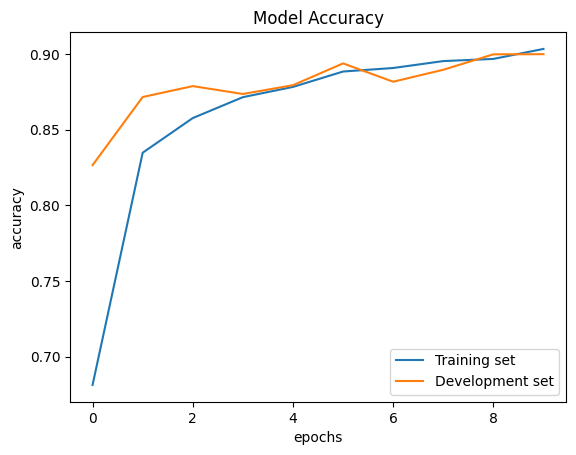

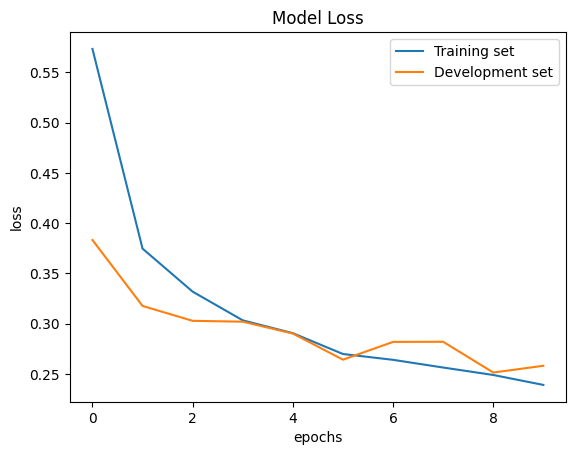

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='upper right')
plt.show()

# Metrics

Precision , Recall , F1 , AUC scores for Bi-LSTM classifier

In [13]:
model = tuner.hypermodel.build(best_hps)
model.fit(train_data, y_train, validation_data=(dev_data, y_dev), batch_size=BATCH_SIZE, epochs=best_epoch, shuffle=True)


rnn_predictions_train = model.predict(train_data)
rnn_precision_train, rnn_recall_train, thresholds = precision_recall_curve(y_train, rnn_predictions_train)

rnn_predictions_dev = model.predict(dev_data)
rnn_precision_dev, rnn_recall_dev, thresholds = precision_recall_curve(y_dev, rnn_predictions_dev)

rnn_predictions_test = model.predict(test_data)
rnn_precision_test, rnn_recall_test, thresholds = precision_recall_curve(y_test, rnn_predictions_test)


print('\n--------- Custom stacked BiLSTM ---------\n')
print('Training set\n')
print(classification_report(y_train, np.round(rnn_predictions_train), target_names = target_names))
print('AUC training :', auc(rnn_recall_train, rnn_precision_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev, np.round(rnn_predictions_dev), target_names = target_names))
print('AUC development :', auc(rnn_recall_dev, rnn_precision_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test, np.round(rnn_predictions_test), target_names = target_names))
print('AUC test :', auc(rnn_recall_test, rnn_precision_test))

Epoch 1/9
118/118 [==============================] - 268s 2s/step - loss: 0.5375 - accuracy: 0.7044 - val_loss: 0.3779 - val_accuracy: 0.8402
Epoch 2/9
118/118 [==============================] - 249s 2s/step - loss: 0.3555 - accuracy: 0.8445 - val_loss: 0.3043 - val_accuracy: 0.8752
Epoch 3/9
118/118 [==============================] - 247s 2s/step - loss: 0.3232 - accuracy: 0.8628 - val_loss: 0.2942 - val_accuracy: 0.8794
Epoch 4/9
118/118 [==============================] - 248s 2s/step - loss: 0.3043 - accuracy: 0.8720 - val_loss: 0.2930 - val_accuracy: 0.8854
Epoch 5/9
118/118 [==============================] - 247s 2s/step - loss: 0.2799 - accuracy: 0.8815 - val_loss: 0.2845 - val_accuracy: 0.8868
Epoch 6/9
118/118 [==============================] - 248s 2s/step - loss: 0.2696 - accuracy: 0.8864 - val_loss: 0.2544 - val_accuracy: 0.8968
Epoch 7/9
118/118 [==============================] - 250s 2s/step - loss: 0.2609 - accuracy: 0.8923 - val_loss: 0.2543 - val_accuracy: 0.8972
Epoch 